In [1]:
# http://openapi.customs.go.kr/openapi/service/newTradestatistics/gettradeList&ServiceKey
import requests # requests 라이브러리 설치 필요
import xmltodict, json

from urllib.request import urlopen
from bs4 import BeautifulSoup

import pandas as pd 
import numpy as np

In [2]:
# 한글 표기를 위한 처리
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [3]:
code_df = pd.read_excel("../data/관세청조회코드_v2.7.xlsx", sheet_name=None)
items_df =code_df['품목별 코드']
country_df = code_df['국가별코드']
sinseong_df =code_df['신성질별코드']
export_df = code_df['수출 수입코드']

In [4]:
items_df

,품목코드,품목명
0,1,산동물
1,101,말ㆍ당나귀ㆍ노새와 버새
2,10110,번식용의 것
3,101101000,말(농가 사육용의 것에 한한다)
4,101109000,기타
...,...,...
17759,970600,골동품(제작후 100년을 초과한 것에 한한다)
17760,9706001000,도자기류
17761,9706002000,악기류
17762,9706009000,기타


In [5]:
# *대상품목(16): 배추, 무, 양파, 건고추, 마늘, 대파, 얼갈이배추, 양배추, 깻잎, 시금치, 미나리, 당근, 파프리카, 새송이, 팽이버섯, 토마토
# *대상품종(5): 청상추, 백다다기, 애호박, 캠벨얼리, 샤인마스캇

list_PUM = ['배추', '무', '양파', '건고추', '마늘', '대파', '얼갈이배추', '양배추', '깻잎', '시금치', '미나리', '당근', '파프리카', '새송이', '팽이버섯', '토마토']
list_KIN = ['청상추', '백다다기', '애호박', '캠벨얼리', '샤인마스캇']

In [61]:
PUM_code_df = items_df[items_df['품목명'].isin(list_PUM)]
len(PUM_code_df)
# PUM_code_df
# items_df[items_df['품목명'].isin(list_KIN)]

print(PUM_code_df['품목명'].unique())
PUM_code_df

['양파' '마늘' '양배추' '배추' '당근' '무' '팽이버섯' '토마토']


,품목코드,품목명
952,703101000,양파
954,70320,마늘
964,704901000,양배추
965,704902000,배추
976,706101000,당근
979,706901000,무
1004,709595000,팽이버섯
1025,710801000,양파
1026,710802000,마늘
1028,710804000,당근


In [7]:
encoding_key_svc = 'rRN59Qk1LaAfk4DLErvPSfBjj0Pj6vOIXDmsTMIyMnbt%2FJVC%2F3NTAbJB2B%2FPFbNza9MvkR1bpbfVbe9uIvjKRA%3D%3D'
decoding_key_svc = 'rRN59Qk1LaAfk4DLErvPSfBjj0Pj6vOIXDmsTMIyMnbt/JVC/3NTAbJB2B/PFbNza9MvkR1bpbfVbe9uIvjKRA=='

url = "http://openapi.customs.go.kr/openapi/service/newTradestatistics/getNitemtradeList?searchBgnDe=201601&searchEndDe=201612&searchItemCd=0202&searchStatCd=US&serviceKey={0}".format(encoding_key_svc)

# respons_data = requests.get('http://apis.data.go.kr/1390802/AgriWeather/WeatherObsrInfo/GnrlWeather/getWeatherTenMinList?serviceKey={0}&Page_No=1&Page_Size=20&date=2018-01-01&obsr_Spot_Nm=가평군 가평읍&obsr_Spot_Code=477802A001'.format(decoding_key_svc))
# respons_data = requests.get(url.format(decoding_key_svc))
respons_data = requests.get(url)

In [8]:
# 조건 검색
year_list = list(range(2000, 2022))
# print(year_list)
month_list = ["01", "12"]
# 시작 년도월
serchBgnDe = "serchBgnDe="
# 끝 년도월 
searchEndDe = "&searchEndDe="
# 품목코드 
serchItemCd = "&serchItemCd="
# 국가명
serchStatCd = "&serchStatCd="

In [9]:
make_url = "http://openapi.customs.go.kr/openapi/service/newTradestatistics/getNitemtradeList?"

In [65]:
foreign_list = ['페루','미국','중국','필리핀','미얀마'
                ,'인디아','호주','베트남','이스라엘', '뉴질랜드'
                ,'칠레','수입산','태국','에쿠아도르','이란'
                ,'남아프리카','기타국','과테말라','일본','말레이지아'
                ,'멕시코','원양산','통가', '대만','스페인'
                ,'코스타리카','우즈베크','아이슬란드','자마이카', '카나다'
                ,'이탈리아', '러시아 연방','벨기에','태평양']
                
cty_df=country_df[country_df['국가명'].isin(foreign_list)]
# cty_df=country_df[country_df['국가명'].isin(['러시아'])]
# cty_dfb

len(foreign_list)

34

In [64]:
forien_contry = ['중국','수입산','필리핀','칠레','태국','뉴질랜드','미국','남아프리카','멕시코','과테말라', '에쿠아도르', '베트남', '페루','콜롬비아',
'호주','미얀마','인디아','중앙아프리카','브라질','우즈베크','북한','러시아 연방', '태평양', '사우디아라비아','인도네시아']

len(forien_contry)


25

In [67]:
forien_contry=['과테말라','기타국','남아프리카','네덜란드','네덜란드 열도','노르웨이','뉴 칼레도니아','뉴질랜드','대만','동남부태평양',
              '러시아','러시아 연방','마세도니아','말레이지아','멕시코','몬트세라트','몽골','미국','미얀마','바레인','베트남','벨기에',
              '북한','불가리아','불령 리유니온_코모도 제도','브라질','사우디아라비아','수단','수입산','스페인','아르메니아','아르헨티나',
               '아이슬란드','안도라','에쿠아도르','영령 인도양','오스트리아','우주베키스탄','우즈베크','우크라이나','원양산','이디오피아',
              '이란', '이스라엘','이집트','이탈리아','인도네시아','인도양','인디아','일본','자마이카','중국','중앙아프리카','체코공화국',
               '칠레','카나다','캄보디아','코스 군도','코스타리카','콜롬비아','크로아티아','태국','태평양','터키','통가','파나마','파키스탄',
               '페루','포클랜드 군도','핀란드','필리핀','호주']
len(forien_contry)

72

In [11]:
def make_url_func(arg_pum, arg_stat):
    make_url = "http://openapi.customs.go.kr/openapi/service/newTradestatistics/getNitemtradeList?"
    encoding_key_svc = 'rRN59Qk1LaAfk4DLErvPSfBjj0Pj6vOIXDmsTMIyMnbt%2FJVC%2F3NTAbJB2B%2FPFbNza9MvkR1bpbfVbe9uIvjKRA%3D%3D'
    # decoding_key_svc = 'rRN59Qk1LaAfk4DLErvPSfBjj0Pj6vOIXDmsTMIyMnbt/JVC/3NTAbJB2B/PFbNza9MvkR1bpbfVbe9uIvjKRA=='
    # 조건 검색
    year_list = list(range(2000, 2022))
    month_list = ["01", "12"]
    # 품목코드 
    serchItemCd = "&serchItemCd="
    # 국가명
    serchStatCd = "&serchStatCd=" 
    svc_key = "&serviceKey=rRN59Qk1LaAfk4DLErvPSfBjj0Pj6vOIXDmsTMIyMnbt%2FJVC%2F3NTAbJB2B%2FPFbNza9MvkR1bpbfVbe9uIvjKRA%3D%3D"

    url =""
    year_list = []
    print("="*50)
    print("arg_pum", arg_pum, "arg_stat", arg_stat)
    
    for y_cnt in range(len(year_list)):
        print(y_cnt)
        # 시작 년도월
        serchBgnDe = "serchBgnDe="
        # 끝 년도월 
        searchEndDe = "&searchEndDe="
        serchBgnDe  = serchBgnDe + str(year_list[y_cnt]) + month_list[0]
        searchEndDe = searchEndDe + str(year_list[y_cnt]) + month_list[1]

        print(serchBgnDe + searchEndDe)
        print("*"*50)
    print("="*50)
    # respons_data = requests.get('http://apis.data.go.kr/1390802/AgriWeather/WeatherObsrInfo/GnrlWeather/getWeatherTenMinList?serviceKey={0}&Page_No=1&Page_Size=20&date=2018-01-01&obsr_Spot_Nm=가평군 가평읍&obsr_Spot_Code=477802A001'.format(decoding_key_svc))
    # respons_data = requests.get(url.format(decoding_key_svc))
    # respons_data = requests.get(url)
    return url

In [53]:
def request_func(arg_url):
    col_dict = {'balPayments':'무역수지', 'impDlr':'수입금액', 'impWgt':'수입중량', 'expDlr':'수출금액', 'expWgt':'수출중량',
                'hsCd':'HS코드', 'statKor':'품목명', 'statCd':'국가코드', 'statCdCntnKor1':'국가명', 'year':'기간'}

    url = arg_url
    respons_data = requests.get(url)
    print(respons_data)
    content=respons_data.content
    print(content)
    content_dict=xmltodict.parse(content)
    print("content_dict", content_dict)
    jsonStr=json.dumps(content_dict['response']['body']['items'], ensure_ascii=False)

    print("="*50)
    print(jsonStr)
    if not jsonStr: 
        jsonObj=json.loads(jsonStr)
        print(type(jsonObj))
        if 'item' in jsonObj.keys():
            pd_obj=pd.DataFrame(jsonObj['item'], columns=col_dict)
        else:
            pd_obj= pd.DataFrame()
        print(pd_obj)
    else:
        return


In [54]:
url = "http://openapi.customs.go.kr/openapi/service/newTradestatistics/getNitemtradeList?serchBgnDe=200001&searchEndDe=200012&serchItemCd=703101000&serchStatCd=AU&serviceKey=rRN59Qk1LaAfk4DLErvPSfBjj0Pj6vOIXDmsTMIyMnbt%2FJVC%2F3NTAbJB2B%2FPFbNza9MvkR1bpbfVbe9uIvjKRA%3D%3D"
request_func(url)

<Response [200]>
b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?><response><header><resultCode>00</resultCode><resultMsg>NORMAL SERVICE.</resultMsg></header><body><items/></body></response>'
content_dict OrderedDict([('response', OrderedDict([('header', OrderedDict([('resultCode', '00'), ('resultMsg', 'NORMAL SERVICE.')])), ('body', OrderedDict([('items', None)]))]))])
null


In [ ]:
# PUM_code_df
# cty_df

url = "http://openapi.customs.go.kr/openapi/service/newTradestatistics/getNitemtradeList?"
# 조건 검색
year_list = list(range(2000, 2022))
# print(year_list)
month_list = ["01", "12"]
# 시작 년도월
serchBgnDe = "serchBgnDe="
# 끝 년도월 
searchEndDe = "&searchEndDe="
# 품목코드 
serchItemCd = "&serchItemCd="
# 국가명
serchStatCd = "&serchStatCd="

svc_key = "&serviceKey=rRN59Qk1LaAfk4DLErvPSfBjj0Pj6vOIXDmsTMIyMnbt%2FJVC%2F3NTAbJB2B%2FPFbNza9MvkR1bpbfVbe9uIvjKRA%3D%3D"

for i, j in cty_df.values:
    for ii, jj in PUM_code_df.values:
        for y_cnt in range(len(year_list)):
            bgn_de = str(year_list[y_cnt]) + month_list[0]
            end_de = str(year_list[y_cnt]) + month_list[1]

            make_url = serchBgnDe + bgn_de + searchEndDe + end_de + serchItemCd + str(ii) + serchStatCd + i + svc_key
            # print(make_url)
            res_url = url + make_url
            print(res_url)
            print("*"*50)
            request_func(res_url)
            break;
            # tot_df = pd.concat(tot_df, df, ignore_index=True)



In [15]:
# make_url_func()

In [16]:
def data_request_func():
    
    return respons_data

In [17]:
len(cty_df)

31

In [18]:
# for cty, nm in cty_df.values:
#     print(cty, nm)

In [19]:
# url.format(encoding_key_svc)
respons_data

<Response [200]>

In [20]:
content=respons_data.content
content_dict=xmltodict.parse(content)
# content_dict


In [21]:
jsonStr=json.dumps(content_dict['response']['body']['items'], ensure_ascii=False)
jsonObj=json.loads(jsonStr)
jsonObj

{'item': [{'balPayments': '-93603291',
   'expDlr': '150822',
   'expWgt': '18003',
   'hsCd': '0202',
   'impDlr': '93754113',
   'impWgt': '14809834',
   'statCd': 'US',
   'statCdCntnKor1': '미국',
   'statKor': '쇠고기(냉동한 것으로 한정한다)',
   'year': '2016.01'},
  {'balPayments': '-49505329',
   'expDlr': '169130',
   'expWgt': '18051',
   'hsCd': '0202',
   'impDlr': '49674459',
   'impWgt': '8592190',
   'statCd': 'US',
   'statCdCntnKor1': '미국',
   'statKor': '쇠고기(냉동한 것으로 한정한다)',
   'year': '2016.02'},
  {'balPayments': '-42048571',
   'expDlr': '0',
   'expWgt': '0',
   'hsCd': '0202',
   'impDlr': '42048571',
   'impWgt': '7274029',
   'statCd': 'US',
   'statCdCntnKor1': '미국',
   'statKor': '쇠고기(냉동한 것으로 한정한다)',
   'year': '2016.03'},
  {'balPayments': '-47107245',
   'expDlr': '0',
   'expWgt': '0',
   'hsCd': '0202',
   'impDlr': '47107245',
   'impWgt': '8142437',
   'statCd': 'US',
   'statCdCntnKor1': '미국',
   'statKor': '쇠고기(냉동한 것으로 한정한다)',
   'year': '2016.04'},
  {'balPayments':

In [22]:
pd_obj=pd.DataFrame(jsonObj['item'])
pd_obj

,balPayments,expDlr,expWgt,hsCd,impDlr,impWgt,statCd,statCdCntnKor1,statKor,year
0,-93603291,150822,18003,0202,93754113,14809834,US,미국,쇠고기(냉동한 것으로 한정한다),2016.01
1,-49505329,169130,18051,0202,49674459,8592190,US,미국,쇠고기(냉동한 것으로 한정한다),2016.02
2,-42048571,0,0,0202,42048571,7274029,US,미국,쇠고기(냉동한 것으로 한정한다),2016.03
3,-47107245,0,0,0202,47107245,8142437,US,미국,쇠고기(냉동한 것으로 한정한다),2016.04
4,-63364870,0,0,0202,63364870,10805844,US,미국,쇠고기(냉동한 것으로 한정한다),2016.05
5,-63149821,306916,21418,0202,63456737,11040639,US,미국,쇠고기(냉동한 것으로 한정한다),2016.06
6,-57094516,0,0,0202,57094516,9980159,US,미국,쇠고기(냉동한 것으로 한정한다),2016.07
7,-81466942,0,0,0202,81466942,14426608,US,미국,쇠고기(냉동한 것으로 한정한다),2016.08
8,-70583966,0,0,0202,70583966,13198366,US,미국,쇠고기(냉동한 것으로 한정한다),2016.09
9,-75331115,0,0,0202,75331115,13838084,US,미국,쇠고기(냉동한 것으로 한정한다),2016.10


In [23]:
col_dict = {'balPayments':'무역수지', 'impDlr':'수입금액', 'impWgt':'수입중량', 'expDlr':'수출금액', 'expWgt':'수출중량',
             'hsCd':'HS코드', 'statKor':'품목명', 'statCd':'국가코드', 'statCdCntnKor1':'국가명', 'year':'기간'}


In [24]:
for key, val in col_dict.items():
    print(key)
    print(val)

balPayments
무역수지
impDlr
수입금액
impWgt
수입중량
expDlr
수출금액
expWgt
수출중량
hsCd
HS코드
statKor
품목명
statCd
국가코드
statCdCntnKor1
국가명
year
기간


In [25]:
pd_obj

,balPayments,expDlr,expWgt,hsCd,impDlr,impWgt,statCd,statCdCntnKor1,statKor,year
0,-93603291,150822,18003,0202,93754113,14809834,US,미국,쇠고기(냉동한 것으로 한정한다),2016.01
1,-49505329,169130,18051,0202,49674459,8592190,US,미국,쇠고기(냉동한 것으로 한정한다),2016.02
2,-42048571,0,0,0202,42048571,7274029,US,미국,쇠고기(냉동한 것으로 한정한다),2016.03
3,-47107245,0,0,0202,47107245,8142437,US,미국,쇠고기(냉동한 것으로 한정한다),2016.04
4,-63364870,0,0,0202,63364870,10805844,US,미국,쇠고기(냉동한 것으로 한정한다),2016.05
5,-63149821,306916,21418,0202,63456737,11040639,US,미국,쇠고기(냉동한 것으로 한정한다),2016.06
6,-57094516,0,0,0202,57094516,9980159,US,미국,쇠고기(냉동한 것으로 한정한다),2016.07
7,-81466942,0,0,0202,81466942,14426608,US,미국,쇠고기(냉동한 것으로 한정한다),2016.08
8,-70583966,0,0,0202,70583966,13198366,US,미국,쇠고기(냉동한 것으로 한정한다),2016.09
9,-75331115,0,0,0202,75331115,13838084,US,미국,쇠고기(냉동한 것으로 한정한다),2016.10


In [26]:
# getNitemtradeList

tot_df = pd.read_excel("../data/관세청조회코드_v2.7.xlsx", sheet_name=None)

In [27]:
# conda install xlrd
# conda install openpyxl

In [28]:
items_df =tot_df['품목별 코드']
country_df = tot_df['국가별코드']
sinseong_df =tot_df['신성질별코드']
export_df = tot_df['수출 수입코드']

In [29]:
# items_df
# sinseong_df
# export_df

In [30]:
import os
os.getcwd()

'c:\\Share_JSSON\\JangbogoProject\\develop'

In [31]:
dir_path = "../data/"

In [32]:
fd_filenm = os.listdir(dir_path)
fd_filenm

['test.txt',
 '국제_석유제품가격20100101-20211013.xls',
 '국제_원유가격20100101-20211013.xls',
 '관세청조회코드_v2.7.xlsx',
 '기상청25_작물별_농업주산지_상세날씨_조회서비스_오픈API활용가이드.docx',
 '소비자물가지수__2010.2021.09.csv',
 '신선식품지수_2010.2021.09.csv',
 '품목별 국가별  수출입실적_2010_미국_러시아.xls',
 '품목별 국가별  수출입실적_2011_미국러시아.xls',
 '품목별 국가별  수출입실적_2012_미국_러시아.xls',
 '품목별 국가별  수출입실적_2013_미국_러시아.xls',
 '품목별 국가별  수출입실적_2014_미국_러시아.xls',
 '품목별 국가별  수출입실적_2015_미국_러시아.xls',
 '품목별 국가별  수출입실적_2017_미국_러시아.xls',
 '품목별 국가별  수출입실적_2018_미국_러시아.xls',
 '품목별 국가별  수출입실적_2019_미국_러시아.xls',
 '품목별 국가별  수출입실적_2020_미국_러시아.xls',
 '품목별 국가별  수출입실적_2021_미국_러시아.xls']

In [33]:
# for f_nm in fd_filenm:
#     print(f_nm[-3:])

In [34]:
fd_filenm=[f_nm for f_nm in fd_filenm if f_nm[-3:]=='xls']

In [35]:
fd_filenm

['국제_석유제품가격20100101-20211013.xls',
 '국제_원유가격20100101-20211013.xls',
 '품목별 국가별  수출입실적_2010_미국_러시아.xls',
 '품목별 국가별  수출입실적_2011_미국러시아.xls',
 '품목별 국가별  수출입실적_2012_미국_러시아.xls',
 '품목별 국가별  수출입실적_2013_미국_러시아.xls',
 '품목별 국가별  수출입실적_2014_미국_러시아.xls',
 '품목별 국가별  수출입실적_2015_미국_러시아.xls',
 '품목별 국가별  수출입실적_2017_미국_러시아.xls',
 '품목별 국가별  수출입실적_2018_미국_러시아.xls',
 '품목별 국가별  수출입실적_2019_미국_러시아.xls',
 '품목별 국가별  수출입실적_2020_미국_러시아.xls',
 '품목별 국가별  수출입실적_2021_미국_러시아.xls']

In [36]:
import os
os.getcwd()
dir_path = "../data/" # 파일위치 폴더 
fd_filenm = os.listdir(dir_path) # 모든 파일명 리스트를 가져옴
fd_filenm=[f_nm for f_nm in fd_filenm if f_nm[-3:]=='xls']

In [37]:
def concat_read_file(arg_fnm_list):
    global dir_path
    fd_path = dir_path

    dfs = pd.DataFrame()
    for fnm in arg_fnm_list:
        df = pd.read_excel(fd_path+fnm, skiprows=[0, 1, 2, 3, 5], thousands=',') # 파일을 열었을때 무시하는 행
        dfs = pd.concat([dfs,df], join='outer', ignore_index=True)
    return dfs 

In [38]:
# df=pd.read_excel(dir_path+"품목별 국가별  수출입실적_202110287.xls", skiprows=[0, 1, 2, 3])

In [39]:
# df

In [ ]:
df=concat_read_file(fd_filenm)

In [ ]:
df

In [42]:
from datetime import datetime

# df.info()
df['기간']= df['기간'].dropna().astype(str)
# datetime.strptime(df['기간'], '%Y%m')


In [ ]:
df['기간']=df['기간'].apply(lambda x: x.replace('.', '')) # 2020.10 > 202010

In [ ]:

df['기간']=df['기간'].apply(lambda x: datetime.strptime(x, '%Y%m'))

In [ ]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23214 entries, 0 to 23213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기간      23214 non-null  datetime64[ns]
 1   품목명     23214 non-null  object        
 2   품목코드    23214 non-null  int64         
 3   국가명     23214 non-null  object        
 4   수출중량    23214 non-null  float64       
 5   수입중량    23214 non-null  float64       
 6   수출금액    23214 non-null  int64         
 7   수입금액    23214 non-null  int64         
 8   무역수지    23214 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 1.6+ MB


,기간,품목명,품목코드,국가명,수출중량,수입중량,수출금액,수입금액,무역수지
0,2010-01-01,살아 있는 동물,1,미국,0.2,20.1,24,3496,-3472
1,2010-01-01,육과 식용 설육(屑肉),2,미국,157.4,18373.7,488,52050,-51562
2,2010-01-01,어류ㆍ갑각류ㆍ연체동물과 그 밖의 수생(水生) 무척추동물,3,미국,833.1,2279.4,4174,5916,-1742
3,2010-01-01,어류ㆍ갑각류ㆍ연체동물과 그 밖의 수생(水生) 무척추동물,3,러시아 연방,952.0,22187.8,771,38798,-38027
4,2010-01-01,"낙농품, 새의 알, 천연꿀, 다른 류로 분류되지 않은 식용인 동물성 생산품",4,미국,360.8,2650.9,347,6043,-5695
...,...,...,...,...,...,...,...,...,...
23209,2021-08-01,잡품,96,미국,966.6,101.6,12113,3880,8233
23210,2021-08-01,예술품ㆍ수집품ㆍ골동품,97,러시아 연방,0.0,0.2,0,113,-113
23211,2021-08-01,예술품ㆍ수집품ㆍ골동품,97,미국,2.3,5.6,4432,16316,-11884
23212,2021-08-01,일시적 입법 ; 설치된 간이 수정에 따른 입법을 트레이드한다 ; 추가적 수입제한농업...,99,러시아 연방,0.0,29.0,0,0,0


In [ ]:
# df[['수출중량', '수입중량', '수출금액', '수입금액', '무역수지']].astype(float)
# df[['수출중량', '수입중량', '수출금액', '수입금액', '무역수지']].astype(float)
# df[['수출중량', '수입중량', '수출금액', '수입금액', '무역수지']].astype(float)
# df[['수출중량', '수입중량', '수출금액', '수입금액', '무역수지']].astype(float)
# df[['수출중량', '수입중량', '수출금액', '수입금액', '무역수지']].astype(float)
# df[['수출중량', '수입중량', '수출금액', '수입금액', '무역수지']].astype(float)
# df.groupby('국가명').mean()

In [ ]:
fig = plt.figure(figsize=(20,15))
chart = fig.add_subplot(1, 1, 1)
chart.plot(df['2010'][['수출금액']], color='blue', label='수출금액')
chart.plot(df['2010'][['수출금액']].rolling(window=12).mean(), color='red', label='수출금액')

In [ ]:
fig = plt.figure(figsize=(20,15))
chart = fig.add_subplot(1, 1, 1)
chart.plot(df[['수출금액']], color='blue', label='수출금액')
chart.plot(df[['수출금액']].rolling(window=12).mean(), color='red', label='수출금액')

In [ ]:
df['2017']

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df.set_index('기간', inplace=True)

<AxesSubplot:xlabel='기간'>

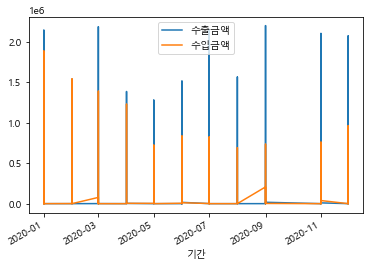

In [ ]:
df['2020'][['수출금액', '수입금액']].plot()

In [ ]:
df['기간_변환']=pd.to_datetime(df['기간'], format='%Y%m')

In [ ]:
# dates

0        2020.01
1        2020.01
2        2020.01
3        2020.01
4        2020.01
          ...   
23209    2021.08
23210    2021.08
23211    2021.08
23212    2021.08
23213    2021.08
Name: 기간, Length: 23214, dtype: object

In [ ]:
foreign_list = ['페루', '미국', '중국', '필리핀', '미얀마', '인디아', '호주', '베트남', '이스라엘', '뉴질랜드', '칠레', '수입산', '태국', '에쿠아도르']
len(foreign_list)

14

In [ ]:
country_df[country_df['국가명'].isin(foreign_list)]
item_cate =['포도', '양파', '당근', '대파']


,국가코드,국가명
13,AU,호주
46,CL,칠레
48,CN,중국
64,EC,에쿠아도르
105,IL,이스라엘
107,IN,인디아
150,MM,미얀마
177,NZ,뉴질랜드
180,PE,페루
183,PH,필리핀


In [ ]:
items_df[items_df['품목명'].isin(item_cate)]

,품목코드,품목명
952,703101000,양파
976,706101000,당근
1025,710801000,양파
1028,710804000,당근
1045,711904000,당근
1054,712200000,양파
1076,712902040,당근
2216,2001909070,양파
2317,2008991000,포도
